<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_06_pytorch_pipeline_03_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### PCA Optimization Notebook Summary

#### Purpose:
The PCA Optimization Notebook aims to identify the optimal number of principal components for dimensionality reduction. It does this by evaluating the performance of a neural network model across a range of PCA components and selecting the number that maximizes the chosen performance metric.

#### What It Does:
1. **Load Preprocessed Data**: Imports the data that has been cleaned and preprocessed in the Data Preparation Notebook.
2. **Set Random Seed**: Ensures reproducibility by setting a random seed.
3. **Initialize Performance Metrics**: Sets up structures to store performance metrics for each number of PCA components evaluated.
4. **Iterative PCA Application**:
   - **Range of Components**: Defines a range of principal components to evaluate.
   - **Pipeline Setup**: Creates a pipeline that includes preprocessing and PCA.
   - **Model Training and Evaluation**: Trains and evaluates a neural network for each number of PCA components.
5. **Store Results**: Records the performance metrics for each number of PCA components.
6. **Plot Results**: Visualizes the performance metrics to identify the optimal number of components.
7. **Select Optimal Components**: Determines the number of components that yields the best performance based on the chosen metric.
8. **Document Findings**: Summarizes the findings and selects the optimal number of principal components for use in subsequent notebooks.

### Key Points:
1. **Load Preprocessed Data**: Uses the preprocessed data saved from the Data Preparation Notebook.
2. **Iterative PCA Application**: Applies PCA across a range of component numbers to find the optimal number.
3. **Model Training and Evaluation**: Trains and evaluates a neural network model for each PCA component count.
4. **Performance Recording**: Records and plots F1-scores for each number of PCA components.
5. **Optimal Components Selection**: Identifies and saves the optimal number of PCA components.

By using this notebook, you can efficiently determine the optimal number of principal components for your dataset, leading to improved model performance and a more streamlined analysis workflow.



## Modular Code

PCA optimization code with modularization and better error handling.

1. **Modularization**: Break down the code into smaller functions or modules. This makes the code easier to read, debug, and maintain.
2. **Consistent Data Handling**: Ensure that data handling is consistent across different parts of the code. Use DataFrames for preprocessing and convert to NumPy arrays or tensors only when necessary.
3. **Error Handling**: Implement better error handling to provide more informative error messages and prevent the code from crashing.
4. **Simplified Iteration**: Streamline the iteration process over PCA components to make it more efficient and less error-prone.
5. **Logging**: Add logging to track the progress of the script and make debugging easier.



In [18]:
#### `ml_utils.py` script

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def load_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
    data = pd.read_excel(url, header=1)
    data.columns = [col.lower().replace(' ', '_') for col in data.columns]
    return data

def preprocess_data(data):
    X = data.drop(columns=['default_payment_next_month', 'id'])
    y = data['default_payment_next_month']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

def define_preprocessor(X_train):
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

class DataFramePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, preprocessor):
        self.preprocessor = preprocessor

    def fit(self, X, y=None):
        self.preprocessor.fit(X, y)
        return self

    def transform(self, X):
        X_transformed = self.preprocessor.transform(X)
        return pd.DataFrame(X_transformed)

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64, pos_weight=1.0):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
        return predictions.numpy().squeeze()

def calculate_class_weights(y_train):
    return len(y_train) / (2 * np.bincount(y_train))

def evaluate_pca(X_train, X_test, y_train, y_test, preprocessor, class_weights):
    n_components_range = range(1, X_train.shape[1] + 1)
    f1_scores = []

    for n_components in n_components_range:
        logging.info(f"Evaluating PCA with {n_components} components")

        pca_pipeline = Pipeline(steps=[
            ('preprocessor', DataFramePreprocessor(preprocessor)),
            ('pca', PCA(n_components=n_components))
        ])

        X_train_pca = pca_pipeline.fit_transform(X_train, y_train)
        X_test_pca = pca_pipeline.transform(X_test)

        undersampler = RandomUnderSampler(sampling_strategy=0.75, random_state=42)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_pca, y_train)

        X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).unsqueeze(1)
        X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)

        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
        nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

        y_pred = nn_estimator.predict(X_test_tensor.numpy())
        f1 = f1_score(y_test_tensor.numpy(), y_pred)
        f1_scores.append(f1)
        logging.info(f"Number of components: {n_components}, F1-score: {f1}")

    return n_components_range, f1_scores

def plot_f1_scores(n_components_range, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_range, f1_scores, marker='o')
    plt.title('F1-Score vs. Number of Principal Components (PCA)')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('F1-Score')
    plt.xticks(n_components_range)
    plt.grid()
    plt.show()


2. **Import Functions in Your Notebook**:
   - Import the functions from `ml_utils.py` into your notebook.

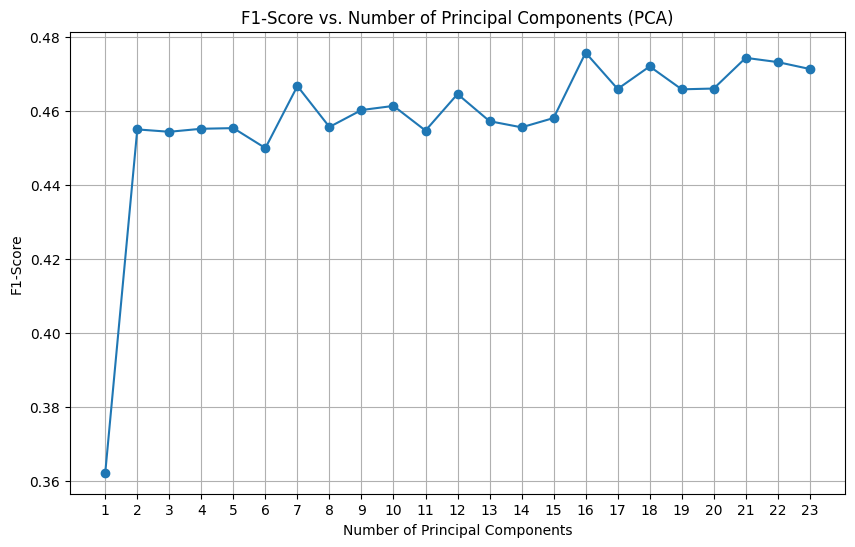

Optimal number of principal components: 16


In [19]:
from ml_utils import set_seed, load_data, preprocess_data, define_preprocessor, calculate_class_weights, evaluate_pca, plot_f1_scores

def main():
    set_seed(42)
    data = load_data()
    X_train, X_test, y_train, y_test = preprocess_data(data)
    preprocessor = define_preprocessor(X_train)
    class_weights = calculate_class_weights(y_train)
    n_components_range, f1_scores = evaluate_pca(X_train, X_test, y_train, y_test, preprocessor, class_weights)
    plot_f1_scores(n_components_range, f1_scores)

    optimal_n_components = n_components_range[np.argmax(f1_scores)]
    print(f"Optimal number of principal components: {optimal_n_components}")

    with open('optimal_pca_components.txt', 'w') as f:
        f.write(str(optimal_n_components))

if __name__ == "__main__":
    main()